### Drive Mounting

In [ ]:
from google.colab import drive
drive.mount('./MyDrive')

Drive already mounted at ./MyDrive; to attempt to forcibly remount, call drive.mount("./MyDrive", force_remount=True).


In [ ]:
cd MyDrive/My Drive/Colab Notebooks/project

/content/MyDrive/My Drive/Colab Notebooks/project


### Package Loading

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torchvision import transforms
from torchvision.datasets import STL10
from torchsummary import summary

from tqdm.notebook import tqdm
import time

### Parameter Setting

In [ ]:
class Config:
    seed = 42
    device = "cuda"if torch.cuda.is_available() else 'cpu'

    epochs = 500
    epochs_fine_training = 50
    batch_size = 100
    n_classes = 10

    lambd = 3
    dim_noise = 100
    image_size = (3, 64, 64)

    d_g_lr = 0.0002
    d_g_beta1 = 0.5

    s_lr = 0.0002
    s_beta1 = 0.5

    g_path = "./checkpoint/meta_pseudo_labels(GAN)/Generator(ResNet50).pt"
    d_path = "./checkpoint/meta_pseudo_labels(GAN)/Discriminator(ResNet50).pt"
    s_path = "./checkpoint/meta_pseudo_labels(GAN)/Student(ResNet50).pt"
    s_fine_training_path = "./checkpoint/meta_pseudo_labels(GAN)/Student_fine_trained(ResNet50).pt"

    history_path = "./history/meta_pseudo_labels(GAN)/history(ResNet50).csv"
    history_fine_training_path = "./history/meta_pseudo_labels(GAN)/history_fine_training(ResNet50).csv"

print(Config.device)

cuda


In [ ]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = True 

In [ ]:
seed_everything(Config.seed)

### Data Loading

In [ ]:
transform = transforms.Compose([transforms.RandomCrop((64, 64)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

In [ ]:
train_ds = STL10('./data', split='train', download=True, transform=transform)
unlabeled_ds = STL10('./data', split='unlabeled', download=True, transform=transform)
test_ds = STL10('./data', split='test', download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_set, valid_set = random_split(train_ds, [4000, 1000])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


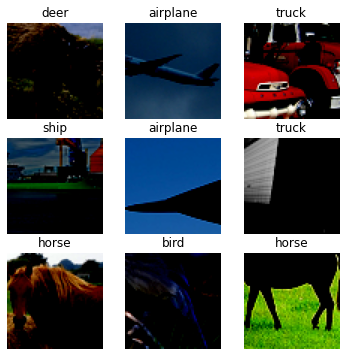

In [ ]:
figure = plt.figure(figsize=(6, 6))

classes = ('airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

In [ ]:
print("labeld size: %d" % (len(train_set)))
print("unlabeld size: %d" % (len(unlabeled_ds)))
print("validation size: %d" % (len(valid_set)))
print("test size: %d" % (len(test_ds)))

labeld size: 4000
unlabeld size: 100000
validation size: 1000
test size: 8000


In [ ]:
labeled_dl = DataLoader(train_set, batch_size=Config.batch_size, shuffle=True)
unlabeled_dl = DataLoader(unlabeled_ds, batch_size=len(train_set), shuffle=True)
valid_dl = DataLoader(valid_set, batch_size=Config.batch_size,)
test_dl = DataLoader(test_ds, batch_size=Config.batch_size)

### Model Defining

Teacher(DCGAN)

In [ ]:
class Generator(nn.Module):
    def __init__(self, dim_noise):
        super(Generator, self).__init__()

        self.layers = nn.Sequential(
            nn.ConvTranspose2d(dim_noise, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

        self.initialize_weights()

    def initialize_weights(self):
        for i in self.modules():
          if isinstance(i, nn.ConvTranspose2d):
              nn.init.normal_(i.weight, mean=0.0, std=0.02)
          elif isinstance(i, nn.BatchNorm2d):
              nn.init.normal_(i.weight, mean=1.0, std=0.02)
              nn.init.constant_(i.bias, 0)

    def forward(self, inputs):
        output = self.layers(inputs)

        return output

In [ ]:
g_model = Generator(dim_noise=Config.dim_noise).to(Config.device)

summary(g_model, input_size = (Config.dim_noise, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, n_classes):
        super(Discriminator, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 10, kernel_size=4, stride=1, padding=0, bias=False),
        )

        self.softmax = nn.Softmax(-1)


        self.initialize_weights()

    def initialize_weights(self):
        for i in self.modules():
          if isinstance(i, nn.Conv2d):
              nn.init.normal_(i.weight, mean=0.0, std=0.02)
          elif isinstance(i, nn.BatchNorm2d):
              nn.init.normal_(i.weight, mean=1.0, std=0.02)
              nn.init.constant_(i.bias, 0)

    def forward(self, inputs):
        x = self.layers(inputs)
        x = x.view(x.shape[0], -1)
        outputs = self.softmax(x)
        return outputs

In [ ]:
d_model = Discriminator(n_classes=Config.n_classes).to(Config.device)

summary(d_model, input_size = Config.image_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13             [-1, 10, 1, 1]          81,920
          Softmax-14                   

Student(ResNet50)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, stride):
        super(ResidualBlock, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=stride, padding=0, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        if in_channels != out_channels:
          self.projection = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
          )

        else:
          self.projection = nn.Sequential()

        self.activation = nn.ReLU(inplace=True)

    def forward(self, inputs):
        x = self.conv_layers(inputs)
        skip_connection = self.projection(inputs)
        x += skip_connection
        outputs = self.activation(x)
        
        return outputs

In [ ]:
class ResNet50(nn.Module):
    def __init__(self, n_classes):
      super(ResNet50, self).__init__()

      self.conv_1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True)
      )

      self.conv_2 = self.make_block(64, 64, 256, 3, True)
      
      self.conv_3 = self.make_block(256, 128 , 512, 4, True)
      
      self.conv_4 = self.make_block(512, 256, 1024, 6, True)

      self.conv_5 = self.make_block(1024, 512, 2048, 3, True)

      self.avg_pooling = nn.AvgPool2d(kernel_size=4, stride=1)

      self.classifier = nn.Sequential(
          nn.Linear(2048, n_classes),
          nn.Softmax(-1)
      )

      self.initialize_weights()

    def make_block(self, in_channels, mid_channels, out_channels, reps, downsampling):
      outputs = []
      
      if downsampling:
        outputs.append(ResidualBlock(in_channels, mid_channels, out_channels, 2))
      
      else:
        outputs.append(ResidualBlock(in_channels, mid_channels, out_channels, 1))

      for i in range(reps-1):
        outputs.append(ResidualBlock(out_channels, mid_channels, out_channels, 1))

      return nn.Sequential(*outputs)

    def initialize_weights(self):
      for i in self.modules():
        if isinstance(i, nn.Conv2d):
            nn.init.kaiming_normal_(i.weight, mode='fan_in', nonlinearity='relu')
        elif isinstance(i, nn.Linear):
            nn.init.kaiming_normal_(i.weight, mode='fan_in', nonlinearity='relu')
            nn.init.constant_(i.bias, 0)
        elif isinstance(i, nn.BatchNorm2d):
            nn.init.normal_(i.weight, mean=1.0, std=0.02)
            nn.init.constant_(i.bias, 0)

    def forward(self, inputs):
      x = self.conv_1(inputs)
      x = self.conv_2(x)
      x = self.conv_3(x)
      x = self.conv_4(x)
      x = self.conv_5(x)
      x = self.avg_pooling(x)
      x = x.view(x.shape[0], -1)
      outputs = self.classifier(x)
        
      return outputs

In [ ]:
s_model = ResNet50(n_classes=Config.n_classes).to(Config.device)

summary(s_model, input_size = (Config.image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]           4,096
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 256, 32, 32]          16,384
      BatchNorm2d-11          [-1, 256, 32, 32]             512
           Conv2d-12          [-1, 256, 32, 32]          16,384
      BatchNorm2d-13          [-1, 256, 32, 32]             512
             ReLU-14          [-1, 256,

### Training Setting

In [ ]:
class MarginalHLoss(nn.Module):
  def __init__(self):
    super(MarginalHLoss, self).__init__()

  def forward(self, x):
    x = x.mean(axis=0)
    x = -torch.sum(x*torch.log(x+1e-6))
    
    return x

In [ ]:
class JointHLoss(nn.Module):
  def __init__(self):
    super(JointHLoss, self).__init__()

  def forward(self, x):
    x = -x*torch.log(x+1e-6)
    x = 1.0/Config.batch_size*x.sum()
    
    return x

In [ ]:
cross_entropy = nn.CrossEntropyLoss(reduction='mean')
marginal_entropy = MarginalHLoss()
joint_entropy = JointHLoss()

d_optimizer = optim.Adam(d_model.parameters(), lr=Config.d_g_lr, betas=(Config.d_g_beta1, 0.999))
g_optimizer = optim.Adam(g_model.parameters(), lr=Config.d_g_lr, betas=(Config.d_g_beta1, 0.999))
s_optimizer = optim.Adam(s_model.parameters(), lr=Config.s_lr, betas=(Config.s_beta1, 0.999))

In [ ]:
def meta_pseudo_labels(g_model, d_model, s_model, g_optimizer, d_optimizer, s_optimizer, lambd, epochs, g_path, d_path, s_path, history_path, labeled_dl, unlabeled_dl, valid_dl):
    history = {'G_loss':[], 'D_loss':[], 'S_loss':[], 'S_valid_acc':[]}        
    start_time = time.time()

    current_label_epoch = 0;
      
    for unlabel_iter in range(int(epochs/len(unlabeled_dl))): 
        for unlabeled_batch, _ in unlabeled_dl:
            epoch_time = time.time()

            total_G_loss = 0
            total_D_loss = 0
            total_S_loss = 0

            s_model.train()
            for (labeled_inputs, labels), i in tqdm(zip(labeled_dl, range(len(labeled_dl))), total=len(labeled_dl), desc="Training", leave=False):
                labeled_inputs, labels = labeled_inputs.to(Config.device), labels.to(Config.device)
                unlabeled_inputs = unlabeled_batch[i*Config.batch_size:(i+1)*Config.batch_size].to(Config.device)

                d_unlabeled_outputs = d_model(unlabeled_inputs)
                _, pseudo_labels = torch.max(d_unlabeled_outputs.detach().data, 1)

                noise = torch.randn(Config.batch_size, Config.dim_noise, 1, 1).to(Config.device)
                fake_inputs = g_model(noise)

                # Train s_model
                s_optimizer.zero_grad()

                s_unlabeled_outputs = s_model(unlabeled_inputs)
                s_labeled_outputs_old = s_model(labeled_inputs)

                s_cross_entropy_unlabeled = cross_entropy(s_unlabeled_outputs, pseudo_labels)

                s_loss = s_cross_entropy_unlabeled
                s_loss.backward(retain_graph=True)
                s_optimizer.step()

                total_S_loss += s_loss.item()

                # Train d_model
                d_optimizer.zero_grad()

                d_labeled_outputs = d_model(labeled_inputs)
                d_fake_outputs = d_model(fake_inputs.detach())

                s_labeled_outputs_new = s_model(labeled_inputs)
                s_cross_entropy_labeled_old = cross_entropy(s_labeled_outputs_old.detach(), labels)
                s_cross_entropy_labeled_new = cross_entropy(s_labeled_outputs_new.detach(), labels)
                coefficient_from_s = s_cross_entropy_labeled_old - s_cross_entropy_labeled_new

                d_cross_entropy_unlabeled = cross_entropy(d_unlabeled_outputs, pseudo_labels)
                d_cross_entropy_labeled = cross_entropy(d_labeled_outputs, labels) 
                d_joint_entropy_fake = joint_entropy(d_fake_outputs) 
                d_marginal_entropy_unlabeled = marginal_entropy(d_unlabeled_outputs)

                d_loss = (coefficient_from_s * d_cross_entropy_unlabeled) + (lambd * d_cross_entropy_labeled) - d_joint_entropy_fake - d_marginal_entropy_unlabeled
                d_loss.backward(retain_graph=True)
                d_optimizer.step()

                total_D_loss += d_loss.item()

                # Train g_model
                g_optimizer.zero_grad()

                d_outputs = d_model(fake_inputs)

                g_joint_entropy = joint_entropy(d_outputs)
                g_marginal_entropy = marginal_entropy(d_outputs)

                g_loss = g_joint_entropy - g_marginal_entropy
                g_loss.backward(retain_graph=True)
                g_optimizer.step()

                total_G_loss += g_loss.item()

            G_loss = total_G_loss / len(labeled_dl)
            D_loss = total_D_loss / len(labeled_dl)
            S_loss = total_S_loss / len(labeled_dl)

            history['G_loss'].append(G_loss)
            history['D_loss'].append(D_loss)
            history['S_loss'].append(S_loss)

            valid_total = 0
            valid_correct = 0

            s_model.eval()
            with torch.no_grad():
              for inputs, labels in tqdm(valid_dl, desc="Validation", leave=False):
                  inputs, labels = inputs.to(Config.device), labels.to(Config.device)
                  outputs = s_model(inputs)
                  _, predicted = torch.max(outputs.data, 1)

                  valid_total += labels.size(0)
                  valid_correct += (predicted == labels).sum().item()

            valid_acc = valid_correct / valid_total * 100

            history['S_valid_acc'].append(valid_acc)

            current_label_epoch += 1
            tqdm.write('[Epoch : %d/%d] G_loss: %.5f, D_loss: %.5f, S_loss: %.5f, S_valid_acc: %.2f, elapsed_time_in_epoch: %02d:%02d' % (current_label_epoch, epochs, G_loss, D_loss, S_loss, valid_acc, (time.time()-epoch_time)/60, (time.time()-epoch_time)%60))

            torch.save(g_model.state_dict(), g_path)
            torch.save(d_model.state_dict(), d_path)
            torch.save(s_model.state_dict(), s_path)

    print('Finished training')
    print('Total elapsed time: %02d:%02d' % ((time.time()-start_time)/60, (time.time()-start_time)%60))

    history_df = pd.DataFrame(history)
    history_df.to_csv(history_path)

    return g_model, d_model, s_model, history

In [ ]:
def fine_training(model, optimizer, epochs, model_path, history_path, train_dl, valid_dl):
    history = {'train_loss':[], 'valid_acc':[]}        
    start_time = time.time()
      
    for epoch in range(epochs): 
        epoch_time = time.time()

        train_losses = 0

        valid_total = 0
        valid_correct = 0

        model.train()
        for inputs, labels in tqdm(train_dl, desc="Training", leave=False):
                inputs, labels = inputs.to(Config.device), labels.to(Config.device)
                optimizer.zero_grad()

                outputs = model(inputs)
                cross_entropy_loss = cross_entropy(outputs, labels)

                loss = cross_entropy_loss
                loss.backward(retain_graph=True)
                optimizer.step()

                train_losses += loss.item()

        train_loss = train_losses / len(train_dl)
        history['train_loss'].append(train_loss)

        model.eval()
        with torch.no_grad():
          for inputs, labels in tqdm(valid_dl, desc="Validation", leave=False):
              inputs, labels = inputs.to(Config.device), labels.to(Config.device)

              outputs = model(inputs)
              _, predicted = torch.max(outputs.data, 1)

              valid_total += labels.size(0)
              valid_correct += (predicted == labels).sum().item()


        valid_acc = valid_correct / valid_total * 100
        history['valid_acc'].append(valid_acc)

        tqdm.write('[Epoch : %d/%d] train_loss: %.5f, valid_acc: %.2f, elapsed_time_in_epoch: %02d:%02d' % (epoch + 1, epochs, train_loss, valid_acc, (time.time()-epoch_time)/60, (time.time()-epoch_time)%60))

        torch.save(model.state_dict(), model_path)

    print('Finished training')
    print('Total elapsed time: %02d:%02d' % ((time.time()-start_time)/60, (time.time()-start_time)%60))

    history_df = pd.DataFrame(history)
    history_df.to_csv(history_path)

    return model, history

### Meta Pseudo Labels

In [ ]:
g_model, d_model, s_model, history = meta_pseudo_labels(g_model, d_model, s_model, g_optimizer, d_optimizer, s_optimizer, Config.lambd, Config.epochs, Config.g_path, Config.d_path, Config.s_path, Config.history_path, labeled_dl, unlabeled_dl, valid_dl)

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 1/500] G_loss: -0.38022, D_loss: 2.78608, S_loss: 2.22850, S_valid_acc: 22.10, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 2/500] G_loss: -0.38158, D_loss: 2.58241, S_loss: 2.13030, S_valid_acc: 25.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 3/500] G_loss: -0.30241, D_loss: 2.45062, S_loss: 2.09650, S_valid_acc: 24.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 4/500] G_loss: -0.27203, D_loss: 2.30699, S_loss: 2.07709, S_valid_acc: 25.10, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 5/500] G_loss: -0.23780, D_loss: 2.27307, S_loss: 2.07072, S_valid_acc: 27.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 6/500] G_loss: -0.21767, D_loss: 2.21604, S_loss: 2.05831, S_valid_acc: 23.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 7/500] G_loss: -0.17139, D_loss: 2.22139, S_loss: 2.05237, S_valid_acc: 29.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 8/500] G_loss: -0.17404, D_loss: 2.05879, S_loss: 2.05624, S_valid_acc: 26.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 9/500] G_loss: -0.14009, D_loss: 1.91550, S_loss: 2.02589, S_valid_acc: 28.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 10/500] G_loss: -0.14812, D_loss: 1.92580, S_loss: 2.02217, S_valid_acc: 31.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 11/500] G_loss: -0.16993, D_loss: 1.92420, S_loss: 1.98012, S_valid_acc: 30.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 12/500] G_loss: -0.16733, D_loss: 1.84779, S_loss: 1.99678, S_valid_acc: 30.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 13/500] G_loss: -0.17193, D_loss: 1.92040, S_loss: 2.01888, S_valid_acc: 31.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 14/500] G_loss: -0.19740, D_loss: 2.00764, S_loss: 2.03628, S_valid_acc: 31.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 15/500] G_loss: -0.16376, D_loss: 1.92152, S_loss: 2.03759, S_valid_acc: 30.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 16/500] G_loss: -0.15096, D_loss: 1.88077, S_loss: 2.02513, S_valid_acc: 30.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 17/500] G_loss: -0.14711, D_loss: 1.86338, S_loss: 2.01446, S_valid_acc: 28.10, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 18/500] G_loss: -0.15701, D_loss: 1.86373, S_loss: 2.01541, S_valid_acc: 33.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 19/500] G_loss: -0.16233, D_loss: 1.84871, S_loss: 2.01739, S_valid_acc: 32.40, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 20/500] G_loss: -0.16085, D_loss: 1.84561, S_loss: 2.02333, S_valid_acc: 33.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 21/500] G_loss: -0.15888, D_loss: 1.79263, S_loss: 2.01767, S_valid_acc: 32.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 22/500] G_loss: -0.14621, D_loss: 1.72967, S_loss: 2.01405, S_valid_acc: 31.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 23/500] G_loss: -0.13317, D_loss: 1.70002, S_loss: 1.99873, S_valid_acc: 35.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 24/500] G_loss: -0.16009, D_loss: 1.73741, S_loss: 2.01761, S_valid_acc: 36.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 25/500] G_loss: -0.16649, D_loss: 1.74052, S_loss: 2.00466, S_valid_acc: 36.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 26/500] G_loss: -0.15113, D_loss: 1.70039, S_loss: 1.98005, S_valid_acc: 35.10, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 27/500] G_loss: -0.15141, D_loss: 1.70635, S_loss: 1.99648, S_valid_acc: 34.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 28/500] G_loss: -0.14404, D_loss: 1.65530, S_loss: 1.99563, S_valid_acc: 35.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 29/500] G_loss: -0.15163, D_loss: 1.67347, S_loss: 1.99655, S_valid_acc: 35.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 30/500] G_loss: -0.14720, D_loss: 1.60430, S_loss: 2.00358, S_valid_acc: 35.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 31/500] G_loss: -0.13668, D_loss: 1.57056, S_loss: 2.00161, S_valid_acc: 35.10, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 32/500] G_loss: -0.14081, D_loss: 1.54507, S_loss: 1.99709, S_valid_acc: 33.40, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 33/500] G_loss: -0.14391, D_loss: 1.55614, S_loss: 1.98789, S_valid_acc: 34.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 34/500] G_loss: -0.12390, D_loss: 1.46773, S_loss: 1.97030, S_valid_acc: 36.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 35/500] G_loss: -0.13796, D_loss: 1.52738, S_loss: 2.00695, S_valid_acc: 34.40, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 36/500] G_loss: -0.14516, D_loss: 1.50923, S_loss: 2.00381, S_valid_acc: 35.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 37/500] G_loss: -0.15296, D_loss: 1.57149, S_loss: 2.02580, S_valid_acc: 36.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 38/500] G_loss: -0.13873, D_loss: 1.47549, S_loss: 1.99630, S_valid_acc: 38.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 39/500] G_loss: -0.14667, D_loss: 1.47541, S_loss: 1.98670, S_valid_acc: 38.10, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 40/500] G_loss: -0.14785, D_loss: 1.50481, S_loss: 1.98963, S_valid_acc: 37.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 41/500] G_loss: -0.13795, D_loss: 1.43557, S_loss: 1.98980, S_valid_acc: 37.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 42/500] G_loss: -0.14980, D_loss: 1.47130, S_loss: 2.00902, S_valid_acc: 37.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 43/500] G_loss: -0.15736, D_loss: 1.51386, S_loss: 1.98667, S_valid_acc: 38.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 44/500] G_loss: -0.15240, D_loss: 1.44407, S_loss: 1.98511, S_valid_acc: 38.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 45/500] G_loss: -0.14713, D_loss: 1.43019, S_loss: 1.98361, S_valid_acc: 38.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 46/500] G_loss: -0.14247, D_loss: 1.41297, S_loss: 1.98076, S_valid_acc: 37.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 47/500] G_loss: -0.13627, D_loss: 1.35348, S_loss: 1.97781, S_valid_acc: 36.40, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 48/500] G_loss: -0.14480, D_loss: 1.39753, S_loss: 1.99754, S_valid_acc: 37.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 49/500] G_loss: -0.14716, D_loss: 1.37018, S_loss: 1.99079, S_valid_acc: 39.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 50/500] G_loss: -0.13369, D_loss: 1.35178, S_loss: 1.97442, S_valid_acc: 38.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 51/500] G_loss: -0.15277, D_loss: 1.43857, S_loss: 2.00797, S_valid_acc: 40.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 52/500] G_loss: -0.14323, D_loss: 1.36459, S_loss: 1.98718, S_valid_acc: 37.40, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 53/500] G_loss: -0.14700, D_loss: 1.35793, S_loss: 1.99243, S_valid_acc: 41.10, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 54/500] G_loss: -0.14233, D_loss: 1.34660, S_loss: 1.99482, S_valid_acc: 41.10, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 55/500] G_loss: -0.14068, D_loss: 1.34000, S_loss: 1.98968, S_valid_acc: 38.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 56/500] G_loss: -0.13483, D_loss: 1.29237, S_loss: 1.98545, S_valid_acc: 36.10, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 57/500] G_loss: -0.13704, D_loss: 1.29139, S_loss: 2.00115, S_valid_acc: 40.10, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 58/500] G_loss: -0.14260, D_loss: 1.29029, S_loss: 1.98131, S_valid_acc: 40.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 59/500] G_loss: -0.16253, D_loss: 1.38502, S_loss: 1.98760, S_valid_acc: 40.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 60/500] G_loss: -0.14059, D_loss: 1.27963, S_loss: 1.98869, S_valid_acc: 39.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 61/500] G_loss: -0.14256, D_loss: 1.28688, S_loss: 1.98227, S_valid_acc: 40.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 62/500] G_loss: -0.14380, D_loss: 1.28362, S_loss: 1.97852, S_valid_acc: 39.10, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 63/500] G_loss: -0.13341, D_loss: 1.24203, S_loss: 1.96580, S_valid_acc: 38.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 64/500] G_loss: -0.14686, D_loss: 1.27375, S_loss: 1.97134, S_valid_acc: 40.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 65/500] G_loss: -0.14651, D_loss: 1.29376, S_loss: 1.96457, S_valid_acc: 42.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 66/500] G_loss: -0.15252, D_loss: 1.29464, S_loss: 1.98867, S_valid_acc: 41.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 67/500] G_loss: -0.15392, D_loss: 1.27398, S_loss: 1.95665, S_valid_acc: 41.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 68/500] G_loss: -0.15261, D_loss: 1.26166, S_loss: 1.98215, S_valid_acc: 40.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 69/500] G_loss: -0.15552, D_loss: 1.28079, S_loss: 2.00759, S_valid_acc: 39.40, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 70/500] G_loss: -0.16475, D_loss: 1.29264, S_loss: 1.97722, S_valid_acc: 40.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 71/500] G_loss: -0.16545, D_loss: 1.29915, S_loss: 1.98101, S_valid_acc: 40.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 72/500] G_loss: -0.14739, D_loss: 1.21893, S_loss: 1.96585, S_valid_acc: 42.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 73/500] G_loss: -0.15353, D_loss: 1.26755, S_loss: 1.97241, S_valid_acc: 41.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 74/500] G_loss: -0.15692, D_loss: 1.25503, S_loss: 1.99706, S_valid_acc: 42.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 75/500] G_loss: -0.17762, D_loss: 1.36046, S_loss: 1.98917, S_valid_acc: 42.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 76/500] G_loss: -0.14790, D_loss: 1.22750, S_loss: 1.95479, S_valid_acc: 42.40, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 77/500] G_loss: -0.14941, D_loss: 1.21813, S_loss: 1.97047, S_valid_acc: 38.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 78/500] G_loss: -0.14029, D_loss: 1.14716, S_loss: 1.96461, S_valid_acc: 39.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 79/500] G_loss: -0.15050, D_loss: 1.18415, S_loss: 1.99495, S_valid_acc: 40.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 80/500] G_loss: -0.14603, D_loss: 1.18076, S_loss: 1.99453, S_valid_acc: 42.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 81/500] G_loss: -0.15424, D_loss: 1.19290, S_loss: 1.97908, S_valid_acc: 42.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 82/500] G_loss: -0.15647, D_loss: 1.17867, S_loss: 1.98413, S_valid_acc: 44.10, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 83/500] G_loss: -0.15407, D_loss: 1.18265, S_loss: 1.96592, S_valid_acc: 42.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 84/500] G_loss: -0.17849, D_loss: 1.28753, S_loss: 1.99909, S_valid_acc: 39.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 85/500] G_loss: -0.16425, D_loss: 1.23400, S_loss: 1.98957, S_valid_acc: 39.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 86/500] G_loss: -0.15747, D_loss: 1.19285, S_loss: 2.00021, S_valid_acc: 42.10, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 87/500] G_loss: -0.14410, D_loss: 1.10156, S_loss: 1.97341, S_valid_acc: 42.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 88/500] G_loss: -0.14407, D_loss: 1.13628, S_loss: 1.98712, S_valid_acc: 42.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 89/500] G_loss: -0.15627, D_loss: 1.17044, S_loss: 1.97953, S_valid_acc: 44.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 90/500] G_loss: -0.16285, D_loss: 1.21678, S_loss: 1.97921, S_valid_acc: 41.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 91/500] G_loss: -0.14876, D_loss: 1.11967, S_loss: 1.95250, S_valid_acc: 42.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 92/500] G_loss: -0.15319, D_loss: 1.11133, S_loss: 1.97799, S_valid_acc: 43.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 93/500] G_loss: -0.16262, D_loss: 1.19109, S_loss: 1.95272, S_valid_acc: 43.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 94/500] G_loss: -0.15601, D_loss: 1.16404, S_loss: 1.97739, S_valid_acc: 42.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 95/500] G_loss: -0.14682, D_loss: 1.05238, S_loss: 1.93741, S_valid_acc: 46.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 96/500] G_loss: -0.15622, D_loss: 1.09636, S_loss: 1.98549, S_valid_acc: 44.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 97/500] G_loss: -0.14571, D_loss: 1.08897, S_loss: 1.96015, S_valid_acc: 44.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 98/500] G_loss: -0.15030, D_loss: 1.08637, S_loss: 1.95346, S_valid_acc: 42.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 99/500] G_loss: -0.17210, D_loss: 1.18634, S_loss: 1.97990, S_valid_acc: 43.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 100/500] G_loss: -0.14464, D_loss: 1.05335, S_loss: 1.95216, S_valid_acc: 45.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 101/500] G_loss: -0.16053, D_loss: 1.10617, S_loss: 1.97905, S_valid_acc: 42.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 102/500] G_loss: -0.16014, D_loss: 1.11450, S_loss: 1.97274, S_valid_acc: 44.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 103/500] G_loss: -0.15704, D_loss: 1.11187, S_loss: 1.98466, S_valid_acc: 46.10, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 104/500] G_loss: -0.15287, D_loss: 1.07487, S_loss: 1.96795, S_valid_acc: 39.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 105/500] G_loss: -0.15803, D_loss: 1.10606, S_loss: 1.98003, S_valid_acc: 42.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 106/500] G_loss: -0.14454, D_loss: 1.01913, S_loss: 1.95692, S_valid_acc: 44.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 107/500] G_loss: -0.14141, D_loss: 1.03806, S_loss: 1.96570, S_valid_acc: 44.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 108/500] G_loss: -0.14138, D_loss: 0.99366, S_loss: 1.97212, S_valid_acc: 45.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 109/500] G_loss: -0.14985, D_loss: 1.03999, S_loss: 1.95317, S_valid_acc: 47.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 110/500] G_loss: -0.15424, D_loss: 1.03663, S_loss: 1.95229, S_valid_acc: 43.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 111/500] G_loss: -0.15088, D_loss: 1.06819, S_loss: 1.92859, S_valid_acc: 45.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 112/500] G_loss: -0.15665, D_loss: 1.07547, S_loss: 1.96245, S_valid_acc: 46.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 113/500] G_loss: -0.14232, D_loss: 1.01859, S_loss: 1.95384, S_valid_acc: 46.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 114/500] G_loss: -0.15665, D_loss: 1.05843, S_loss: 1.93815, S_valid_acc: 45.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 115/500] G_loss: -0.14798, D_loss: 1.00751, S_loss: 1.95555, S_valid_acc: 48.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 116/500] G_loss: -0.14943, D_loss: 0.99555, S_loss: 1.94798, S_valid_acc: 46.40, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 117/500] G_loss: -0.14928, D_loss: 0.98624, S_loss: 1.94276, S_valid_acc: 45.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 118/500] G_loss: -0.14133, D_loss: 0.96046, S_loss: 1.95046, S_valid_acc: 47.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 119/500] G_loss: -0.13645, D_loss: 0.95984, S_loss: 1.94509, S_valid_acc: 46.40, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 120/500] G_loss: -0.15303, D_loss: 1.01465, S_loss: 1.95971, S_valid_acc: 47.10, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 121/500] G_loss: -0.17188, D_loss: 1.10592, S_loss: 1.96533, S_valid_acc: 44.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 122/500] G_loss: -0.16379, D_loss: 1.06320, S_loss: 1.95846, S_valid_acc: 47.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 123/500] G_loss: -0.14594, D_loss: 0.94714, S_loss: 1.92559, S_valid_acc: 45.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 124/500] G_loss: -0.14290, D_loss: 0.95620, S_loss: 1.93798, S_valid_acc: 42.40, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 125/500] G_loss: -0.15806, D_loss: 0.99268, S_loss: 1.96832, S_valid_acc: 45.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 126/500] G_loss: -0.16163, D_loss: 1.03571, S_loss: 1.94477, S_valid_acc: 45.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 127/500] G_loss: -0.13844, D_loss: 0.91639, S_loss: 1.94386, S_valid_acc: 48.40, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 128/500] G_loss: -0.13956, D_loss: 0.92102, S_loss: 1.93162, S_valid_acc: 47.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 129/500] G_loss: -0.14731, D_loss: 0.94702, S_loss: 1.94356, S_valid_acc: 47.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 130/500] G_loss: -0.14746, D_loss: 0.94233, S_loss: 1.93636, S_valid_acc: 48.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 131/500] G_loss: -0.15647, D_loss: 0.94824, S_loss: 1.93914, S_valid_acc: 48.10, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 132/500] G_loss: -0.15225, D_loss: 0.95045, S_loss: 1.95020, S_valid_acc: 45.40, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 133/500] G_loss: -0.17360, D_loss: 1.04423, S_loss: 1.95952, S_valid_acc: 46.10, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 134/500] G_loss: -0.14856, D_loss: 0.89756, S_loss: 1.94183, S_valid_acc: 50.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 135/500] G_loss: -0.14978, D_loss: 0.91062, S_loss: 1.93493, S_valid_acc: 48.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 136/500] G_loss: -0.15212, D_loss: 0.95160, S_loss: 1.93889, S_valid_acc: 45.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 137/500] G_loss: -0.13928, D_loss: 0.87870, S_loss: 1.91407, S_valid_acc: 50.40, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 138/500] G_loss: -0.14930, D_loss: 0.92180, S_loss: 1.93271, S_valid_acc: 47.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 139/500] G_loss: -0.15246, D_loss: 0.93402, S_loss: 1.92230, S_valid_acc: 47.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 140/500] G_loss: -0.15040, D_loss: 0.92021, S_loss: 1.92735, S_valid_acc: 48.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 141/500] G_loss: -0.15287, D_loss: 0.92951, S_loss: 1.93268, S_valid_acc: 48.10, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 142/500] G_loss: -0.14969, D_loss: 0.88550, S_loss: 1.90929, S_valid_acc: 49.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 143/500] G_loss: -0.14377, D_loss: 0.87112, S_loss: 1.93329, S_valid_acc: 46.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 144/500] G_loss: -0.15432, D_loss: 0.88278, S_loss: 1.94419, S_valid_acc: 48.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 145/500] G_loss: -0.17300, D_loss: 0.97670, S_loss: 1.92832, S_valid_acc: 51.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 146/500] G_loss: -0.15158, D_loss: 0.87225, S_loss: 1.93571, S_valid_acc: 45.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 147/500] G_loss: -0.14862, D_loss: 0.88764, S_loss: 1.93311, S_valid_acc: 46.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 148/500] G_loss: -0.13710, D_loss: 0.81805, S_loss: 1.94360, S_valid_acc: 48.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 149/500] G_loss: -0.15488, D_loss: 0.88898, S_loss: 1.94416, S_valid_acc: 49.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 150/500] G_loss: -0.14557, D_loss: 0.84742, S_loss: 1.93048, S_valid_acc: 48.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 151/500] G_loss: -0.14513, D_loss: 0.85841, S_loss: 1.93668, S_valid_acc: 50.40, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 152/500] G_loss: -0.15529, D_loss: 0.89369, S_loss: 1.94638, S_valid_acc: 49.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 153/500] G_loss: -0.16668, D_loss: 0.93408, S_loss: 1.95595, S_valid_acc: 53.40, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 154/500] G_loss: -0.15025, D_loss: 0.87064, S_loss: 1.92809, S_valid_acc: 49.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 155/500] G_loss: -0.14047, D_loss: 0.82581, S_loss: 1.92655, S_valid_acc: 50.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 156/500] G_loss: -0.15179, D_loss: 0.83463, S_loss: 1.92012, S_valid_acc: 47.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 157/500] G_loss: -0.13864, D_loss: 0.81034, S_loss: 1.93122, S_valid_acc: 49.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 158/500] G_loss: -0.14913, D_loss: 0.83577, S_loss: 1.93583, S_valid_acc: 50.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 159/500] G_loss: -0.13709, D_loss: 0.80229, S_loss: 1.92801, S_valid_acc: 51.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 160/500] G_loss: -0.14824, D_loss: 0.84813, S_loss: 1.92703, S_valid_acc: 49.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 161/500] G_loss: -0.13919, D_loss: 0.80692, S_loss: 1.94461, S_valid_acc: 48.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 162/500] G_loss: -0.14667, D_loss: 0.82752, S_loss: 1.93385, S_valid_acc: 52.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 163/500] G_loss: -0.14702, D_loss: 0.81867, S_loss: 1.92524, S_valid_acc: 51.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 164/500] G_loss: -0.14167, D_loss: 0.81488, S_loss: 1.92089, S_valid_acc: 51.40, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 165/500] G_loss: -0.14715, D_loss: 0.80818, S_loss: 1.91663, S_valid_acc: 50.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 166/500] G_loss: -0.14382, D_loss: 0.80978, S_loss: 1.91352, S_valid_acc: 51.10, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 167/500] G_loss: -0.14913, D_loss: 0.85520, S_loss: 1.94578, S_valid_acc: 50.10, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 168/500] G_loss: -0.15246, D_loss: 0.83571, S_loss: 1.92848, S_valid_acc: 46.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 169/500] G_loss: -0.14901, D_loss: 0.81516, S_loss: 1.92272, S_valid_acc: 52.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 170/500] G_loss: -0.14638, D_loss: 0.76799, S_loss: 1.91758, S_valid_acc: 53.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 171/500] G_loss: -0.14572, D_loss: 0.78653, S_loss: 1.91369, S_valid_acc: 53.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 172/500] G_loss: -0.12475, D_loss: 0.71707, S_loss: 1.91554, S_valid_acc: 52.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 173/500] G_loss: -0.13103, D_loss: 0.71743, S_loss: 1.90716, S_valid_acc: 51.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 174/500] G_loss: -0.13743, D_loss: 0.74942, S_loss: 1.90745, S_valid_acc: 51.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 175/500] G_loss: -0.13939, D_loss: 0.75133, S_loss: 1.90212, S_valid_acc: 52.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 176/500] G_loss: -0.13347, D_loss: 0.73891, S_loss: 1.89923, S_valid_acc: 52.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 177/500] G_loss: -0.13040, D_loss: 0.72885, S_loss: 1.91470, S_valid_acc: 52.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 178/500] G_loss: -0.13907, D_loss: 0.74874, S_loss: 1.90079, S_valid_acc: 55.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 179/500] G_loss: -0.13751, D_loss: 0.73764, S_loss: 1.91053, S_valid_acc: 51.40, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 180/500] G_loss: -0.13580, D_loss: 0.70310, S_loss: 1.91286, S_valid_acc: 53.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 181/500] G_loss: -0.13953, D_loss: 0.73435, S_loss: 1.92319, S_valid_acc: 49.40, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 182/500] G_loss: -0.13651, D_loss: 0.71716, S_loss: 1.93028, S_valid_acc: 50.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 183/500] G_loss: -0.15208, D_loss: 0.79028, S_loss: 1.90396, S_valid_acc: 51.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 184/500] G_loss: -0.16600, D_loss: 0.81081, S_loss: 1.92991, S_valid_acc: 53.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 185/500] G_loss: -0.14511, D_loss: 0.78086, S_loss: 1.90786, S_valid_acc: 53.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 186/500] G_loss: -0.13433, D_loss: 0.72392, S_loss: 1.91394, S_valid_acc: 52.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 187/500] G_loss: -0.13522, D_loss: 0.71216, S_loss: 1.90958, S_valid_acc: 50.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 188/500] G_loss: -0.13599, D_loss: 0.71333, S_loss: 1.93315, S_valid_acc: 49.10, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 189/500] G_loss: -0.13860, D_loss: 0.71369, S_loss: 1.93088, S_valid_acc: 49.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 190/500] G_loss: -0.13823, D_loss: 0.73807, S_loss: 1.92137, S_valid_acc: 51.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 191/500] G_loss: -0.14571, D_loss: 0.73135, S_loss: 1.92779, S_valid_acc: 49.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 192/500] G_loss: -0.21067, D_loss: 0.93636, S_loss: 1.93524, S_valid_acc: 53.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 193/500] G_loss: -0.11932, D_loss: 0.66727, S_loss: 1.91323, S_valid_acc: 48.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 194/500] G_loss: -0.13078, D_loss: 0.67694, S_loss: 1.92533, S_valid_acc: 50.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 195/500] G_loss: -0.14152, D_loss: 0.70800, S_loss: 1.90669, S_valid_acc: 52.10, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 196/500] G_loss: -0.13064, D_loss: 0.67049, S_loss: 1.90260, S_valid_acc: 54.40, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 197/500] G_loss: -0.13244, D_loss: 0.67156, S_loss: 1.92136, S_valid_acc: 48.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 198/500] G_loss: -0.15461, D_loss: 0.76914, S_loss: 1.93070, S_valid_acc: 54.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 199/500] G_loss: -0.14102, D_loss: 0.70120, S_loss: 1.92236, S_valid_acc: 53.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 200/500] G_loss: -0.13746, D_loss: 0.69379, S_loss: 1.92151, S_valid_acc: 50.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 201/500] G_loss: -0.14368, D_loss: 0.68797, S_loss: 1.91576, S_valid_acc: 50.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 202/500] G_loss: -0.14043, D_loss: 0.69034, S_loss: 1.91824, S_valid_acc: 52.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 203/500] G_loss: -0.12264, D_loss: 0.64002, S_loss: 1.91893, S_valid_acc: 53.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 204/500] G_loss: -0.13542, D_loss: 0.67415, S_loss: 1.91224, S_valid_acc: 55.40, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 205/500] G_loss: -0.14963, D_loss: 0.70741, S_loss: 1.92058, S_valid_acc: 52.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 206/500] G_loss: -0.13444, D_loss: 0.66859, S_loss: 1.91211, S_valid_acc: 51.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 207/500] G_loss: -0.13134, D_loss: 0.66369, S_loss: 1.90963, S_valid_acc: 50.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 208/500] G_loss: -0.14591, D_loss: 0.68392, S_loss: 1.91806, S_valid_acc: 53.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 209/500] G_loss: -0.15370, D_loss: 0.70858, S_loss: 1.91428, S_valid_acc: 53.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 210/500] G_loss: -0.13377, D_loss: 0.64936, S_loss: 1.90910, S_valid_acc: 55.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 211/500] G_loss: -0.13518, D_loss: 0.64258, S_loss: 1.91109, S_valid_acc: 54.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 212/500] G_loss: -0.16383, D_loss: 0.74003, S_loss: 1.94128, S_valid_acc: 52.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 213/500] G_loss: -0.14747, D_loss: 0.68519, S_loss: 1.91904, S_valid_acc: 52.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 214/500] G_loss: -0.13864, D_loss: 0.65373, S_loss: 1.93065, S_valid_acc: 56.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 215/500] G_loss: -0.13835, D_loss: 0.64327, S_loss: 1.91697, S_valid_acc: 52.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 216/500] G_loss: -0.13996, D_loss: 0.64132, S_loss: 1.93121, S_valid_acc: 48.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 217/500] G_loss: -0.13951, D_loss: 0.63228, S_loss: 1.91242, S_valid_acc: 55.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 218/500] G_loss: -0.14322, D_loss: 0.64458, S_loss: 1.91654, S_valid_acc: 51.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 219/500] G_loss: -0.14799, D_loss: 0.66073, S_loss: 1.90720, S_valid_acc: 56.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 220/500] G_loss: -0.14722, D_loss: 0.66472, S_loss: 1.91728, S_valid_acc: 53.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 221/500] G_loss: -0.14136, D_loss: 0.64482, S_loss: 1.91867, S_valid_acc: 56.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 222/500] G_loss: -0.13182, D_loss: 0.60153, S_loss: 1.89956, S_valid_acc: 55.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 223/500] G_loss: -0.13211, D_loss: 0.61219, S_loss: 1.91594, S_valid_acc: 54.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 224/500] G_loss: -0.15056, D_loss: 0.68285, S_loss: 1.91104, S_valid_acc: 53.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 225/500] G_loss: -0.13818, D_loss: 0.63126, S_loss: 1.90591, S_valid_acc: 52.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 226/500] G_loss: -0.13709, D_loss: 0.62967, S_loss: 1.89216, S_valid_acc: 54.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 227/500] G_loss: -0.15669, D_loss: 0.68460, S_loss: 1.89889, S_valid_acc: 53.40, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 228/500] G_loss: -0.14754, D_loss: 0.64469, S_loss: 1.91427, S_valid_acc: 53.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 229/500] G_loss: -0.13054, D_loss: 0.56883, S_loss: 1.90319, S_valid_acc: 54.40, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 230/500] G_loss: -0.13883, D_loss: 0.59963, S_loss: 1.90626, S_valid_acc: 52.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 231/500] G_loss: -0.15280, D_loss: 0.69922, S_loss: 1.91634, S_valid_acc: 54.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 232/500] G_loss: -0.14033, D_loss: 0.60377, S_loss: 1.90405, S_valid_acc: 52.30, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 233/500] G_loss: -0.13922, D_loss: 0.60315, S_loss: 1.93137, S_valid_acc: 52.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 234/500] G_loss: -0.14432, D_loss: 0.60204, S_loss: 1.91855, S_valid_acc: 54.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 235/500] G_loss: -0.13257, D_loss: 0.55395, S_loss: 1.89990, S_valid_acc: 52.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 236/500] G_loss: -0.12505, D_loss: 0.55212, S_loss: 1.92027, S_valid_acc: 54.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 237/500] G_loss: -0.13962, D_loss: 0.59324, S_loss: 1.91611, S_valid_acc: 56.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 238/500] G_loss: -0.14201, D_loss: 0.60472, S_loss: 1.90715, S_valid_acc: 55.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 239/500] G_loss: -0.13202, D_loss: 0.56749, S_loss: 1.89903, S_valid_acc: 55.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 240/500] G_loss: -0.13038, D_loss: 0.55262, S_loss: 1.92400, S_valid_acc: 52.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 241/500] G_loss: -0.13495, D_loss: 0.56925, S_loss: 1.92074, S_valid_acc: 54.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 242/500] G_loss: -0.13034, D_loss: 0.57830, S_loss: 1.91094, S_valid_acc: 53.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 243/500] G_loss: -0.13159, D_loss: 0.54753, S_loss: 1.90150, S_valid_acc: 54.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 244/500] G_loss: -0.14445, D_loss: 0.63257, S_loss: 1.91050, S_valid_acc: 53.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 245/500] G_loss: -0.14018, D_loss: 0.55589, S_loss: 1.90454, S_valid_acc: 53.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 246/500] G_loss: -0.12988, D_loss: 0.55637, S_loss: 1.90201, S_valid_acc: 54.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 247/500] G_loss: -0.13413, D_loss: 0.55801, S_loss: 1.90923, S_valid_acc: 55.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 248/500] G_loss: -0.14259, D_loss: 0.56680, S_loss: 1.91361, S_valid_acc: 53.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 249/500] G_loss: -0.19580, D_loss: 0.74704, S_loss: 1.91239, S_valid_acc: 52.10, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 250/500] G_loss: -0.13599, D_loss: 0.57613, S_loss: 1.90509, S_valid_acc: 54.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 251/500] G_loss: -0.12814, D_loss: 0.54265, S_loss: 1.89625, S_valid_acc: 56.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 252/500] G_loss: -0.12305, D_loss: 0.52148, S_loss: 1.90070, S_valid_acc: 55.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 253/500] G_loss: -0.13215, D_loss: 0.52322, S_loss: 1.88489, S_valid_acc: 56.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 254/500] G_loss: -0.13416, D_loss: 0.53528, S_loss: 1.89326, S_valid_acc: 53.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 255/500] G_loss: -0.15558, D_loss: 0.64038, S_loss: 1.91226, S_valid_acc: 56.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 256/500] G_loss: -0.13168, D_loss: 0.53780, S_loss: 1.89811, S_valid_acc: 54.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 257/500] G_loss: -0.13654, D_loss: 0.53684, S_loss: 1.89171, S_valid_acc: 55.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 258/500] G_loss: -0.13713, D_loss: 0.52438, S_loss: 1.90360, S_valid_acc: 56.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 259/500] G_loss: -0.14270, D_loss: 0.55633, S_loss: 1.90801, S_valid_acc: 53.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 260/500] G_loss: -0.14407, D_loss: 0.55672, S_loss: 1.92707, S_valid_acc: 52.40, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 261/500] G_loss: -0.13551, D_loss: 0.54797, S_loss: 1.90991, S_valid_acc: 55.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 262/500] G_loss: -0.14179, D_loss: 0.53288, S_loss: 1.90463, S_valid_acc: 55.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 263/500] G_loss: -0.13893, D_loss: 0.52902, S_loss: 1.91096, S_valid_acc: 53.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 264/500] G_loss: -0.13384, D_loss: 0.53620, S_loss: 1.89813, S_valid_acc: 54.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 265/500] G_loss: -0.12751, D_loss: 0.50962, S_loss: 1.89606, S_valid_acc: 55.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 266/500] G_loss: -0.12921, D_loss: 0.50849, S_loss: 1.89944, S_valid_acc: 54.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 267/500] G_loss: -0.12641, D_loss: 0.48616, S_loss: 1.89737, S_valid_acc: 54.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 268/500] G_loss: -0.13361, D_loss: 0.51270, S_loss: 1.88971, S_valid_acc: 55.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 269/500] G_loss: -0.14902, D_loss: 0.57812, S_loss: 1.89529, S_valid_acc: 57.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 270/500] G_loss: -0.13821, D_loss: 0.51947, S_loss: 1.90829, S_valid_acc: 55.10, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 271/500] G_loss: -0.14355, D_loss: 0.54998, S_loss: 1.91123, S_valid_acc: 53.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 272/500] G_loss: -0.12455, D_loss: 0.47064, S_loss: 1.90248, S_valid_acc: 57.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 273/500] G_loss: -0.12811, D_loss: 0.49322, S_loss: 1.90820, S_valid_acc: 55.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 274/500] G_loss: -0.13249, D_loss: 0.49330, S_loss: 1.91235, S_valid_acc: 56.40, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 275/500] G_loss: -0.12829, D_loss: 0.47953, S_loss: 1.90203, S_valid_acc: 55.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 276/500] G_loss: -0.13511, D_loss: 0.50865, S_loss: 1.91636, S_valid_acc: 56.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 277/500] G_loss: -0.13921, D_loss: 0.50434, S_loss: 1.90778, S_valid_acc: 55.10, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 278/500] G_loss: -0.13591, D_loss: 0.49425, S_loss: 1.91560, S_valid_acc: 55.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 279/500] G_loss: -0.13593, D_loss: 0.49720, S_loss: 1.90539, S_valid_acc: 53.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 280/500] G_loss: -0.13021, D_loss: 0.50207, S_loss: 1.91463, S_valid_acc: 54.50, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 281/500] G_loss: -0.13396, D_loss: 0.48726, S_loss: 1.91642, S_valid_acc: 56.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 282/500] G_loss: -0.12822, D_loss: 0.46397, S_loss: 1.91012, S_valid_acc: 55.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 283/500] G_loss: -0.13413, D_loss: 0.48054, S_loss: 1.89802, S_valid_acc: 53.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 284/500] G_loss: -0.13624, D_loss: 0.50324, S_loss: 1.90892, S_valid_acc: 57.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 285/500] G_loss: -0.12994, D_loss: 0.46274, S_loss: 1.89738, S_valid_acc: 57.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 286/500] G_loss: -0.17658, D_loss: 0.61390, S_loss: 1.91744, S_valid_acc: 55.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 287/500] G_loss: -0.16138, D_loss: 0.59643, S_loss: 1.91223, S_valid_acc: 56.10, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 288/500] G_loss: -0.12835, D_loss: 0.45816, S_loss: 1.90564, S_valid_acc: 55.10, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 289/500] G_loss: -0.12320, D_loss: 0.44356, S_loss: 1.88917, S_valid_acc: 56.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 290/500] G_loss: -0.13749, D_loss: 0.49634, S_loss: 1.91434, S_valid_acc: 55.60, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 291/500] G_loss: -0.13644, D_loss: 0.45368, S_loss: 1.90178, S_valid_acc: 54.50, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 292/500] G_loss: -0.14258, D_loss: 0.51321, S_loss: 1.90909, S_valid_acc: 54.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 293/500] G_loss: -0.13937, D_loss: 0.48123, S_loss: 1.88609, S_valid_acc: 55.20, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 294/500] G_loss: -0.13478, D_loss: 0.45643, S_loss: 1.91040, S_valid_acc: 56.90, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 295/500] G_loss: -0.13704, D_loss: 0.48724, S_loss: 1.91362, S_valid_acc: 55.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 296/500] G_loss: -0.13530, D_loss: 0.45769, S_loss: 1.90470, S_valid_acc: 57.40, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 297/500] G_loss: -0.14821, D_loss: 0.52959, S_loss: 1.90302, S_valid_acc: 57.80, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 298/500] G_loss: -0.13317, D_loss: 0.45508, S_loss: 1.91399, S_valid_acc: 56.10, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 299/500] G_loss: -0.13462, D_loss: 0.46939, S_loss: 1.91529, S_valid_acc: 54.30, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 300/500] G_loss: -0.13222, D_loss: 0.42881, S_loss: 1.90243, S_valid_acc: 58.00, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 301/500] G_loss: -0.13450, D_loss: 0.45805, S_loss: 1.90976, S_valid_acc: 58.70, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 302/500] G_loss: -0.13948, D_loss: 0.47673, S_loss: 1.91875, S_valid_acc: 57.70, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 303/500] G_loss: -0.14947, D_loss: 0.50357, S_loss: 1.90316, S_valid_acc: 53.30, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 304/500] G_loss: -0.13502, D_loss: 0.44396, S_loss: 1.88781, S_valid_acc: 57.40, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 305/500] G_loss: -0.13040, D_loss: 0.42948, S_loss: 1.91699, S_valid_acc: 56.50, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 306/500] G_loss: -0.12841, D_loss: 0.42287, S_loss: 1.90490, S_valid_acc: 55.30, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 307/500] G_loss: -0.13427, D_loss: 0.45085, S_loss: 1.91234, S_valid_acc: 56.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 308/500] G_loss: -0.14027, D_loss: 0.45682, S_loss: 1.91816, S_valid_acc: 57.10, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 309/500] G_loss: -0.17906, D_loss: 0.59112, S_loss: 1.91407, S_valid_acc: 56.40, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 310/500] G_loss: -0.11842, D_loss: 0.39871, S_loss: 1.90457, S_valid_acc: 54.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 311/500] G_loss: -0.12682, D_loss: 0.41665, S_loss: 1.90031, S_valid_acc: 56.80, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 312/500] G_loss: -0.12713, D_loss: 0.41405, S_loss: 1.90485, S_valid_acc: 56.10, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 313/500] G_loss: -0.13502, D_loss: 0.44279, S_loss: 1.89056, S_valid_acc: 56.60, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 314/500] G_loss: -0.12733, D_loss: 0.40764, S_loss: 1.90757, S_valid_acc: 54.50, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 315/500] G_loss: -0.13069, D_loss: 0.41789, S_loss: 1.91241, S_valid_acc: 55.50, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 316/500] G_loss: -0.12996, D_loss: 0.41203, S_loss: 1.87919, S_valid_acc: 57.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 317/500] G_loss: -0.13206, D_loss: 0.41210, S_loss: 1.90019, S_valid_acc: 57.40, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 318/500] G_loss: -0.13838, D_loss: 0.43166, S_loss: 1.91991, S_valid_acc: 56.50, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 319/500] G_loss: -0.13845, D_loss: 0.46821, S_loss: 1.90290, S_valid_acc: 59.90, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 320/500] G_loss: -0.13712, D_loss: 0.43116, S_loss: 1.89487, S_valid_acc: 56.30, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 321/500] G_loss: -0.13484, D_loss: 0.42264, S_loss: 1.90974, S_valid_acc: 57.10, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 322/500] G_loss: -0.13942, D_loss: 0.43976, S_loss: 1.89035, S_valid_acc: 60.00, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 323/500] G_loss: -0.15607, D_loss: 0.50030, S_loss: 1.89020, S_valid_acc: 54.00, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 324/500] G_loss: -0.13993, D_loss: 0.43842, S_loss: 1.89831, S_valid_acc: 55.70, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 325/500] G_loss: -0.13164, D_loss: 0.40575, S_loss: 1.88960, S_valid_acc: 56.20, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 326/500] G_loss: -0.13500, D_loss: 0.40860, S_loss: 1.89002, S_valid_acc: 58.30, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 327/500] G_loss: -0.12913, D_loss: 0.40341, S_loss: 1.87865, S_valid_acc: 59.10, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 328/500] G_loss: -0.13596, D_loss: 0.41746, S_loss: 1.89598, S_valid_acc: 57.10, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 329/500] G_loss: -0.14904, D_loss: 0.44719, S_loss: 1.89347, S_valid_acc: 58.00, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 330/500] G_loss: -0.12585, D_loss: 0.37251, S_loss: 1.88741, S_valid_acc: 58.90, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 331/500] G_loss: -0.13260, D_loss: 0.40637, S_loss: 1.90783, S_valid_acc: 59.50, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 332/500] G_loss: -0.13017, D_loss: 0.39673, S_loss: 1.89208, S_valid_acc: 59.00, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 333/500] G_loss: -0.13927, D_loss: 0.43047, S_loss: 1.88428, S_valid_acc: 57.80, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 334/500] G_loss: -0.15030, D_loss: 0.46039, S_loss: 1.90747, S_valid_acc: 57.60, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 335/500] G_loss: -0.12944, D_loss: 0.38928, S_loss: 1.88452, S_valid_acc: 58.00, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 336/500] G_loss: -0.12426, D_loss: 0.36113, S_loss: 1.88196, S_valid_acc: 55.60, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 337/500] G_loss: -0.13408, D_loss: 0.40505, S_loss: 1.90653, S_valid_acc: 58.80, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 338/500] G_loss: -0.14045, D_loss: 0.39325, S_loss: 1.91427, S_valid_acc: 55.60, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 339/500] G_loss: -0.13670, D_loss: 0.42048, S_loss: 1.90927, S_valid_acc: 57.80, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 340/500] G_loss: -0.12093, D_loss: 0.36067, S_loss: 1.89513, S_valid_acc: 55.90, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 341/500] G_loss: -0.12944, D_loss: 0.37547, S_loss: 1.89157, S_valid_acc: 55.80, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 342/500] G_loss: -0.12982, D_loss: 0.36809, S_loss: 1.90034, S_valid_acc: 57.00, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 343/500] G_loss: -0.12865, D_loss: 0.34628, S_loss: 1.89689, S_valid_acc: 55.80, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 344/500] G_loss: -0.12877, D_loss: 0.36841, S_loss: 1.89922, S_valid_acc: 56.50, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 345/500] G_loss: -0.14300, D_loss: 0.41613, S_loss: 1.89526, S_valid_acc: 57.80, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 346/500] G_loss: -0.14457, D_loss: 0.43624, S_loss: 1.89602, S_valid_acc: 58.20, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 347/500] G_loss: -0.13270, D_loss: 0.36516, S_loss: 1.89784, S_valid_acc: 56.80, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 348/500] G_loss: -0.12574, D_loss: 0.35939, S_loss: 1.89157, S_valid_acc: 55.90, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 349/500] G_loss: -0.12504, D_loss: 0.34870, S_loss: 1.87522, S_valid_acc: 58.10, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 350/500] G_loss: -0.13255, D_loss: 0.36393, S_loss: 1.88713, S_valid_acc: 55.10, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 351/500] G_loss: -0.13438, D_loss: 0.38495, S_loss: 1.90507, S_valid_acc: 58.80, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 352/500] G_loss: -0.14216, D_loss: 0.39858, S_loss: 1.90655, S_valid_acc: 58.10, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 353/500] G_loss: -0.14053, D_loss: 0.41002, S_loss: 1.91478, S_valid_acc: 55.80, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 354/500] G_loss: -0.13515, D_loss: 0.38262, S_loss: 1.90594, S_valid_acc: 57.20, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 355/500] G_loss: -0.13234, D_loss: 0.36707, S_loss: 1.90017, S_valid_acc: 56.40, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 356/500] G_loss: -0.13160, D_loss: 0.36886, S_loss: 1.90140, S_valid_acc: 57.00, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 357/500] G_loss: -0.31713, D_loss: 0.90502, S_loss: 1.95035, S_valid_acc: 58.30, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 358/500] G_loss: -0.12817, D_loss: 0.36837, S_loss: 1.90524, S_valid_acc: 57.10, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 359/500] G_loss: -0.11976, D_loss: 0.32896, S_loss: 1.87455, S_valid_acc: 58.80, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 360/500] G_loss: -0.12724, D_loss: 0.35466, S_loss: 1.88751, S_valid_acc: 56.60, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 361/500] G_loss: -0.13236, D_loss: 0.35011, S_loss: 1.89874, S_valid_acc: 57.80, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 362/500] G_loss: -0.13722, D_loss: 0.36364, S_loss: 1.90470, S_valid_acc: 56.30, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 363/500] G_loss: -0.12994, D_loss: 0.35506, S_loss: 1.89866, S_valid_acc: 58.20, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 364/500] G_loss: -0.13791, D_loss: 0.34441, S_loss: 1.90717, S_valid_acc: 57.20, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 365/500] G_loss: -0.11622, D_loss: 0.31701, S_loss: 1.89317, S_valid_acc: 56.70, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 366/500] G_loss: -0.11632, D_loss: 0.31040, S_loss: 1.89158, S_valid_acc: 57.70, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 367/500] G_loss: -0.12710, D_loss: 0.35590, S_loss: 1.88159, S_valid_acc: 57.30, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 368/500] G_loss: -0.12431, D_loss: 0.32552, S_loss: 1.88265, S_valid_acc: 57.10, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 369/500] G_loss: -0.12973, D_loss: 0.35466, S_loss: 1.92162, S_valid_acc: 56.60, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 370/500] G_loss: -0.13109, D_loss: 0.35767, S_loss: 1.88057, S_valid_acc: 58.90, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 371/500] G_loss: -0.13117, D_loss: 0.35370, S_loss: 1.89199, S_valid_acc: 58.90, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 372/500] G_loss: -0.13708, D_loss: 0.35873, S_loss: 1.89276, S_valid_acc: 57.30, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 373/500] G_loss: -0.12477, D_loss: 0.32923, S_loss: 1.89575, S_valid_acc: 57.40, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 374/500] G_loss: -0.13179, D_loss: 0.32839, S_loss: 1.89644, S_valid_acc: 59.90, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 375/500] G_loss: -0.12101, D_loss: 0.31495, S_loss: 1.89195, S_valid_acc: 56.20, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 376/500] G_loss: -0.12630, D_loss: 0.32747, S_loss: 1.91415, S_valid_acc: 57.70, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 377/500] G_loss: -0.13140, D_loss: 0.34541, S_loss: 1.91099, S_valid_acc: 55.70, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 378/500] G_loss: -0.12916, D_loss: 0.34330, S_loss: 1.90334, S_valid_acc: 58.80, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 379/500] G_loss: -0.12189, D_loss: 0.30243, S_loss: 1.90314, S_valid_acc: 60.00, elapsed_time_in_epoch: 00:18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 380/500] G_loss: -0.12897, D_loss: 0.32623, S_loss: 1.88764, S_valid_acc: 55.30, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 381/500] G_loss: -0.13638, D_loss: 0.35742, S_loss: 1.90065, S_valid_acc: 55.00, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 382/500] G_loss: -0.13706, D_loss: 0.34620, S_loss: 1.89242, S_valid_acc: 58.10, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 383/500] G_loss: -0.16478, D_loss: 0.45015, S_loss: 1.89181, S_valid_acc: 59.20, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 384/500] G_loss: -0.12618, D_loss: 0.32057, S_loss: 1.88441, S_valid_acc: 57.90, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 385/500] G_loss: -0.13799, D_loss: 0.37875, S_loss: 1.90786, S_valid_acc: 57.50, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 386/500] G_loss: -0.12358, D_loss: 0.31342, S_loss: 1.89690, S_valid_acc: 58.90, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 387/500] G_loss: -0.11996, D_loss: 0.29896, S_loss: 1.87265, S_valid_acc: 59.40, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 388/500] G_loss: -0.13576, D_loss: 0.35819, S_loss: 1.89054, S_valid_acc: 59.50, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 389/500] G_loss: -0.12636, D_loss: 0.31705, S_loss: 1.87542, S_valid_acc: 58.10, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 390/500] G_loss: -0.12772, D_loss: 0.31149, S_loss: 1.89508, S_valid_acc: 60.40, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 391/500] G_loss: -0.13965, D_loss: 0.35089, S_loss: 1.88955, S_valid_acc: 59.00, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 392/500] G_loss: -0.12743, D_loss: 0.30785, S_loss: 1.88573, S_valid_acc: 58.40, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 393/500] G_loss: -0.13850, D_loss: 0.35292, S_loss: 1.89737, S_valid_acc: 58.60, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 394/500] G_loss: -0.15417, D_loss: 0.41022, S_loss: 1.89759, S_valid_acc: 59.10, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 395/500] G_loss: -0.12620, D_loss: 0.29269, S_loss: 1.89314, S_valid_acc: 57.40, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 396/500] G_loss: -0.12308, D_loss: 0.29149, S_loss: 1.90527, S_valid_acc: 58.10, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 397/500] G_loss: -0.12496, D_loss: 0.32136, S_loss: 1.89413, S_valid_acc: 57.80, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 398/500] G_loss: -0.12103, D_loss: 0.29437, S_loss: 1.89016, S_valid_acc: 58.40, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 399/500] G_loss: -0.11452, D_loss: 0.25907, S_loss: 1.87416, S_valid_acc: 58.70, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 400/500] G_loss: -0.12474, D_loss: 0.29789, S_loss: 1.88827, S_valid_acc: 59.80, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 401/500] G_loss: -0.12952, D_loss: 0.32768, S_loss: 1.88013, S_valid_acc: 58.60, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 402/500] G_loss: -0.12860, D_loss: 0.30819, S_loss: 1.89158, S_valid_acc: 58.70, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 403/500] G_loss: -0.13103, D_loss: 0.29989, S_loss: 1.89400, S_valid_acc: 59.60, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 404/500] G_loss: -0.12235, D_loss: 0.29075, S_loss: 1.88151, S_valid_acc: 60.40, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 405/500] G_loss: -0.12184, D_loss: 0.29869, S_loss: 1.88195, S_valid_acc: 59.00, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 406/500] G_loss: -0.15638, D_loss: 0.38588, S_loss: 1.91569, S_valid_acc: 61.20, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 407/500] G_loss: -0.14306, D_loss: 0.34949, S_loss: 1.89626, S_valid_acc: 58.70, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 408/500] G_loss: -0.13759, D_loss: 0.34099, S_loss: 1.90161, S_valid_acc: 57.50, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 409/500] G_loss: -0.12286, D_loss: 0.27503, S_loss: 1.89033, S_valid_acc: 61.00, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 410/500] G_loss: -0.12935, D_loss: 0.30976, S_loss: 1.90402, S_valid_acc: 57.10, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 411/500] G_loss: -0.13097, D_loss: 0.30447, S_loss: 1.90118, S_valid_acc: 58.70, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 412/500] G_loss: -0.12742, D_loss: 0.28111, S_loss: 1.89457, S_valid_acc: 58.60, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 413/500] G_loss: -0.12417, D_loss: 0.29518, S_loss: 1.87967, S_valid_acc: 60.80, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 414/500] G_loss: -0.12272, D_loss: 0.28110, S_loss: 1.90035, S_valid_acc: 61.10, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 415/500] G_loss: -0.12261, D_loss: 0.26602, S_loss: 1.87757, S_valid_acc: 59.20, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 416/500] G_loss: -0.12773, D_loss: 0.30509, S_loss: 1.87810, S_valid_acc: 59.40, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 417/500] G_loss: -0.15423, D_loss: 0.35970, S_loss: 1.90129, S_valid_acc: 58.40, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 418/500] G_loss: -0.13041, D_loss: 0.28083, S_loss: 1.91505, S_valid_acc: 58.90, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 419/500] G_loss: -0.12728, D_loss: 0.27498, S_loss: 1.90289, S_valid_acc: 60.30, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 420/500] G_loss: -0.18722, D_loss: 0.46417, S_loss: 1.91628, S_valid_acc: 59.70, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 421/500] G_loss: -0.15105, D_loss: 0.39232, S_loss: 1.89556, S_valid_acc: 59.10, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 422/500] G_loss: -0.11535, D_loss: 0.26536, S_loss: 1.88374, S_valid_acc: 61.50, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 423/500] G_loss: -0.11681, D_loss: 0.26425, S_loss: 1.87662, S_valid_acc: 60.00, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 424/500] G_loss: -0.11677, D_loss: 0.24350, S_loss: 1.87652, S_valid_acc: 61.10, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 425/500] G_loss: -0.11205, D_loss: 0.24465, S_loss: 1.88939, S_valid_acc: 59.20, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 426/500] G_loss: -0.12654, D_loss: 0.27879, S_loss: 1.88810, S_valid_acc: 60.20, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 427/500] G_loss: -0.12252, D_loss: 0.27338, S_loss: 1.88307, S_valid_acc: 58.30, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 428/500] G_loss: -0.13609, D_loss: 0.31384, S_loss: 1.89813, S_valid_acc: 58.60, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 429/500] G_loss: -0.12922, D_loss: 0.28204, S_loss: 1.90806, S_valid_acc: 57.20, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 430/500] G_loss: -0.12411, D_loss: 0.28029, S_loss: 1.89736, S_valid_acc: 58.70, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 431/500] G_loss: -0.13830, D_loss: 0.32342, S_loss: 1.89534, S_valid_acc: 59.00, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 432/500] G_loss: -0.12778, D_loss: 0.27280, S_loss: 1.89276, S_valid_acc: 58.40, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 433/500] G_loss: -0.13508, D_loss: 0.30817, S_loss: 1.90846, S_valid_acc: 59.80, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 434/500] G_loss: -0.12695, D_loss: 0.26937, S_loss: 1.88817, S_valid_acc: 57.00, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 435/500] G_loss: -0.13280, D_loss: 0.28512, S_loss: 1.89796, S_valid_acc: 59.20, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 436/500] G_loss: -0.13101, D_loss: 0.28431, S_loss: 1.90089, S_valid_acc: 60.70, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 437/500] G_loss: -0.13332, D_loss: 0.29082, S_loss: 1.89995, S_valid_acc: 58.70, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 438/500] G_loss: -0.13262, D_loss: 0.29762, S_loss: 1.89779, S_valid_acc: 58.00, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 439/500] G_loss: -0.12358, D_loss: 0.26024, S_loss: 1.88849, S_valid_acc: 59.00, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 440/500] G_loss: -0.12275, D_loss: 0.23368, S_loss: 1.87016, S_valid_acc: 59.30, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 441/500] G_loss: -0.12712, D_loss: 0.27963, S_loss: 1.88786, S_valid_acc: 59.00, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 442/500] G_loss: -0.13505, D_loss: 0.29047, S_loss: 1.90462, S_valid_acc: 59.90, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 443/500] G_loss: -0.13145, D_loss: 0.28776, S_loss: 1.88579, S_valid_acc: 60.00, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 444/500] G_loss: -0.13580, D_loss: 0.31190, S_loss: 1.89470, S_valid_acc: 62.20, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 445/500] G_loss: -0.12398, D_loss: 0.24833, S_loss: 1.88006, S_valid_acc: 60.60, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 446/500] G_loss: -0.12583, D_loss: 0.25548, S_loss: 1.89092, S_valid_acc: 60.20, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 447/500] G_loss: -0.12898, D_loss: 0.27025, S_loss: 1.87707, S_valid_acc: 58.20, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 448/500] G_loss: -0.12217, D_loss: 0.23668, S_loss: 1.87866, S_valid_acc: 58.80, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 449/500] G_loss: -0.12320, D_loss: 0.23937, S_loss: 1.88463, S_valid_acc: 60.60, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 450/500] G_loss: -0.12741, D_loss: 0.25522, S_loss: 1.88582, S_valid_acc: 59.60, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 451/500] G_loss: -0.11882, D_loss: 0.24244, S_loss: 1.88292, S_valid_acc: 59.50, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 452/500] G_loss: -0.12665, D_loss: 0.26098, S_loss: 1.89273, S_valid_acc: 60.70, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 453/500] G_loss: -0.11895, D_loss: 0.23649, S_loss: 1.88447, S_valid_acc: 60.50, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 454/500] G_loss: -0.11884, D_loss: 0.23367, S_loss: 1.88316, S_valid_acc: 58.10, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 455/500] G_loss: -0.12018, D_loss: 0.23987, S_loss: 1.89674, S_valid_acc: 61.80, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 456/500] G_loss: -0.14220, D_loss: 0.30862, S_loss: 1.90065, S_valid_acc: 58.50, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 457/500] G_loss: -0.12331, D_loss: 0.25278, S_loss: 1.88775, S_valid_acc: 60.70, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 458/500] G_loss: -0.12274, D_loss: 0.24303, S_loss: 1.88306, S_valid_acc: 60.20, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 459/500] G_loss: -0.15814, D_loss: 0.38090, S_loss: 1.89420, S_valid_acc: 59.00, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 460/500] G_loss: -0.12423, D_loss: 0.24666, S_loss: 1.88937, S_valid_acc: 57.80, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 461/500] G_loss: -0.11716, D_loss: 0.23505, S_loss: 1.86917, S_valid_acc: 59.00, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 462/500] G_loss: -0.11566, D_loss: 0.21398, S_loss: 1.88172, S_valid_acc: 58.10, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 463/500] G_loss: -0.11795, D_loss: 0.23407, S_loss: 1.90006, S_valid_acc: 59.80, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 464/500] G_loss: -0.12322, D_loss: 0.24130, S_loss: 1.89899, S_valid_acc: 58.40, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 465/500] G_loss: -0.13442, D_loss: 0.25901, S_loss: 1.90410, S_valid_acc: 58.70, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 466/500] G_loss: -0.12239, D_loss: 0.22844, S_loss: 1.87890, S_valid_acc: 59.80, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 467/500] G_loss: -0.16917, D_loss: 0.38266, S_loss: 1.89142, S_valid_acc: 59.80, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 468/500] G_loss: -0.11620, D_loss: 0.22393, S_loss: 1.87899, S_valid_acc: 59.90, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 469/500] G_loss: -0.12090, D_loss: 0.23196, S_loss: 1.91120, S_valid_acc: 59.30, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 470/500] G_loss: -0.11719, D_loss: 0.22639, S_loss: 1.90478, S_valid_acc: 58.20, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 471/500] G_loss: -0.12267, D_loss: 0.23157, S_loss: 1.88972, S_valid_acc: 61.80, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 472/500] G_loss: -0.11795, D_loss: 0.22608, S_loss: 1.91344, S_valid_acc: 61.40, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 473/500] G_loss: -0.11744, D_loss: 0.22611, S_loss: 1.87723, S_valid_acc: 59.40, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 474/500] G_loss: -0.11593, D_loss: 0.21621, S_loss: 1.86800, S_valid_acc: 60.40, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 475/500] G_loss: -0.12115, D_loss: 0.22102, S_loss: 1.88581, S_valid_acc: 58.90, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 476/500] G_loss: -0.11687, D_loss: 0.21265, S_loss: 1.87535, S_valid_acc: 60.80, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 477/500] G_loss: -0.12643, D_loss: 0.24457, S_loss: 1.88396, S_valid_acc: 59.70, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 478/500] G_loss: -0.11687, D_loss: 0.22550, S_loss: 1.89336, S_valid_acc: 61.40, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 479/500] G_loss: -0.11430, D_loss: 0.21217, S_loss: 1.87323, S_valid_acc: 60.90, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 480/500] G_loss: -0.11999, D_loss: 0.23061, S_loss: 1.89165, S_valid_acc: 59.70, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 481/500] G_loss: -0.11953, D_loss: 0.21691, S_loss: 1.87554, S_valid_acc: 60.40, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 482/500] G_loss: -0.12073, D_loss: 0.24105, S_loss: 1.89305, S_valid_acc: 60.60, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 483/500] G_loss: -0.16685, D_loss: 0.39637, S_loss: 1.90110, S_valid_acc: 57.10, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 484/500] G_loss: -0.12935, D_loss: 0.26386, S_loss: 1.88658, S_valid_acc: 60.40, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 485/500] G_loss: -0.11653, D_loss: 0.20573, S_loss: 1.89779, S_valid_acc: 59.40, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 486/500] G_loss: -0.11654, D_loss: 0.19465, S_loss: 1.89271, S_valid_acc: 60.60, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 487/500] G_loss: -0.12022, D_loss: 0.21748, S_loss: 1.87300, S_valid_acc: 61.20, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 488/500] G_loss: -0.12985, D_loss: 0.25355, S_loss: 1.89303, S_valid_acc: 59.20, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 489/500] G_loss: -0.11471, D_loss: 0.21490, S_loss: 1.87245, S_valid_acc: 58.70, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 490/500] G_loss: -0.10849, D_loss: 0.18935, S_loss: 1.88002, S_valid_acc: 60.60, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 491/500] G_loss: -0.12601, D_loss: 0.23700, S_loss: 1.87383, S_valid_acc: 60.10, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 492/500] G_loss: -0.12060, D_loss: 0.22494, S_loss: 1.88325, S_valid_acc: 62.30, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 493/500] G_loss: -0.11783, D_loss: 0.20180, S_loss: 1.87550, S_valid_acc: 60.00, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 494/500] G_loss: -0.11368, D_loss: 0.19697, S_loss: 1.87304, S_valid_acc: 59.50, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 495/500] G_loss: -0.11450, D_loss: 0.18824, S_loss: 1.88294, S_valid_acc: 61.80, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 496/500] G_loss: -0.11534, D_loss: 0.20078, S_loss: 1.86679, S_valid_acc: 59.70, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 497/500] G_loss: -0.11628, D_loss: 0.19920, S_loss: 1.88149, S_valid_acc: 62.20, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 498/500] G_loss: -0.15661, D_loss: 0.34051, S_loss: 1.89575, S_valid_acc: 60.30, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 499/500] G_loss: -0.11663, D_loss: 0.19334, S_loss: 1.88266, S_valid_acc: 61.30, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 500/500] G_loss: -0.11608, D_loss: 0.20893, S_loss: 1.88887, S_valid_acc: 59.30, elapsed_time_in_epoch: 00:19
Finished training
Total elapsed time: 176:09


### Fine Training

In [ ]:
s_model.load_state_dict(torch.load(Config.s_path))

<All keys matched successfully>

In [ ]:
s_model, history = fine_training(s_model, s_optimizer, Config.epochs_fine_training, Config.s_fine_training_path, Config.history_fine_training_path, labeled_dl, valid_dl)

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 1/50] train_loss: 1.81542, valid_acc: 62.00, elapsed_time_in_epoch: 00:11


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 2/50] train_loss: 1.80218, valid_acc: 61.20, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 3/50] train_loss: 1.78324, valid_acc: 61.30, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 4/50] train_loss: 1.79348, valid_acc: 62.10, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 5/50] train_loss: 1.79700, valid_acc: 61.50, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 6/50] train_loss: 1.78696, valid_acc: 62.90, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 7/50] train_loss: 1.78338, valid_acc: 60.40, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 8/50] train_loss: 1.76312, valid_acc: 61.60, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 9/50] train_loss: 1.76900, valid_acc: 61.20, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 10/50] train_loss: 1.77966, valid_acc: 60.20, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 11/50] train_loss: 1.77994, valid_acc: 63.70, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 12/50] train_loss: 1.76375, valid_acc: 60.60, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 13/50] train_loss: 1.77367, valid_acc: 62.20, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 14/50] train_loss: 1.74983, valid_acc: 63.00, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 15/50] train_loss: 1.76376, valid_acc: 60.40, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 16/50] train_loss: 1.76015, valid_acc: 60.80, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 17/50] train_loss: 1.77096, valid_acc: 61.70, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 18/50] train_loss: 1.76358, valid_acc: 64.00, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 19/50] train_loss: 1.76429, valid_acc: 62.10, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 20/50] train_loss: 1.75864, valid_acc: 62.10, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 21/50] train_loss: 1.75873, valid_acc: 63.60, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 22/50] train_loss: 1.75448, valid_acc: 61.70, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 23/50] train_loss: 1.75344, valid_acc: 63.70, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 24/50] train_loss: 1.76055, valid_acc: 62.40, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 25/50] train_loss: 1.73982, valid_acc: 62.10, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 26/50] train_loss: 1.73968, valid_acc: 64.80, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 27/50] train_loss: 1.74622, valid_acc: 61.00, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 28/50] train_loss: 1.74610, valid_acc: 64.90, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 29/50] train_loss: 1.74308, valid_acc: 60.10, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 30/50] train_loss: 1.74144, valid_acc: 61.70, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 31/50] train_loss: 1.73584, valid_acc: 63.60, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 32/50] train_loss: 1.72141, valid_acc: 63.30, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 33/50] train_loss: 1.72984, valid_acc: 63.20, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 34/50] train_loss: 1.73057, valid_acc: 61.20, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 35/50] train_loss: 1.72461, valid_acc: 63.60, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 36/50] train_loss: 1.73411, valid_acc: 63.10, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 37/50] train_loss: 1.73437, valid_acc: 63.90, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 38/50] train_loss: 1.73336, valid_acc: 64.30, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 39/50] train_loss: 1.72580, valid_acc: 62.70, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 40/50] train_loss: 1.74420, valid_acc: 63.00, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 41/50] train_loss: 1.72412, valid_acc: 62.80, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 42/50] train_loss: 1.72494, valid_acc: 65.10, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 43/50] train_loss: 1.71933, valid_acc: 65.00, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 44/50] train_loss: 1.71373, valid_acc: 61.10, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 45/50] train_loss: 1.71746, valid_acc: 63.40, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 46/50] train_loss: 1.72202, valid_acc: 62.30, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 47/50] train_loss: 1.70651, valid_acc: 64.70, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 48/50] train_loss: 1.70836, valid_acc: 65.10, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 49/50] train_loss: 1.70740, valid_acc: 65.10, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 50/50] train_loss: 1.71373, valid_acc: 62.40, elapsed_time_in_epoch: 00:10
Finished training
Total elapsed time: 08:51


### Testing

In [ ]:
d_model.load_state_dict(torch.load(Config.d_path))

test_total = 0
test_correct = 0

d_model.eval()
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.to(Config.device), labels.to(Config.device)
        outputs = d_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = test_correct / test_total * 100
print("d_model test_acc: %.5f" %(test_acc))

d_model test_acc: 70.21250


In [ ]:
s_model.load_state_dict(torch.load(Config.s_path))

test_total = 0
test_correct = 0

s_model.eval()
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.to(Config.device), labels.to(Config.device)
        outputs = s_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = test_correct / test_total * 100
print("s_model test_acc: %.5f" %(test_acc))

s_model test_acc: 62.37500


In [ ]:
s_model.load_state_dict(torch.load(Config.s_fine_training_path))

test_total = 0
test_correct = 0

s_model.eval()
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.to(Config.device), labels.to(Config.device)
        outputs = s_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = test_correct / test_total * 100
print("s_model_fine_trained test_acc: %.5f" %(test_acc))

s_model_fine_trained test_acc: 65.15000
